# Reverse modeling of Methane emission spectrum using precomputed spectrum grids

The opacity calculators in ExoJAX are fully auto-differentiable. However, in some case, the precomputation of the spectrum and the interpolation of the grid model are useful to perform rapid reverse modeling. Here, we demonstrate the grid-based retrieval using ExoJAX.   For this example, you might need a good GPU.

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp
from jax import vmap

import pandas as pd
import pkg_resources

from exojax.rt.atmrt import ArtEmisPure
from exojax.database.api  import MdbExomol
from exojax.opacity import OpaPremodit
from exojax.database.contdb  import CdbCIA
from exojax.opacity import OpaCIA
from exojax.postproc.response import ipgauss_sampling
from exojax.postproc.spin_rotation import convolve_rigid_rotation
from exojax.database import molinfo 
from exojax.utils.grids import nu2wav
from exojax.utils.grids import velocity_grid
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.grids import wavenumber_grid
from exojax.utils.instfunc import resolution_to_gaussian_std
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW


2024-09-29 07:22:17.164712: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.20). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


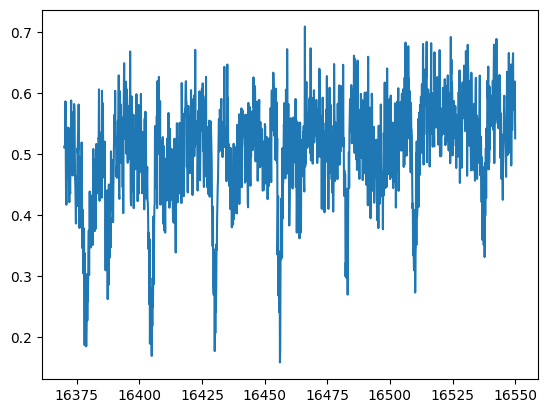

In [4]:

filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd)

sigmain = 0.05
norm = 20000
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))

plt.plot(wavd, nflux)
plt.show()

We make the grid model using ArtEmissPure and MdbExomol.

In [5]:

# set wavenumber grid for the model
Nx = 7500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 10.0,
                                    np.max(wavd) + 10.0,
                                    Nx,
                                    unit='AA',
                                    xsmode='premodit')

Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid=nu_grid, pressure_top=1.e-5, pressure_btm=1.e2, nlayer=75)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2
Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

## CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('# of lines = ', len(mdb.nu_lines))
diffmode = 1
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=1.0)

## CIA setting
cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

#settings before HMC
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)

#given gravity, temperature exponent, MMR
g = gravity_jupiter(Rp=0.88, Mp=33.2)
alpha = 0.1
MMR_CH4 = 0.0059

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)
HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4
radis engine =  vaex
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10.def


/home/kawahara/exojax/src/exojax/utils.grids.py:62: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:144: UserWarning: Resolution may be too small. R=617160.1067701889
  warnings.warn("Resolution may be too small. R=" + str(resolution), UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:63: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.", UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_sim

		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10.pf
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10.states.bz2
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/12C-1H4__H2.broad
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/12C-1H4__He.broad
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/12C-1H4__air.broad
Note: Caching states data to the vaex format. After the second time, it will become much faster.
Molecule:  CH4
Isotopologue:  12C-1H4
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CH4/12C-1H4/YT10to10
Transition files: 
	 => File 12C-1H4__YT10to10__06000-06100.trans
		 => Downloading from http://www.exomol.com/db/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
		 => Caching the *.trans.bz2 file to the vaex (*.h5) format. After the second time, it will become much faster.
		 => You can deleted the 'trans.bz2' file by hand.
	 => 

/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.0488 cm^-1 and n = 0.4) are used for J'' > 16 up to J'' = 40
  warnings.warn(


# of lines =  80505310


/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798953 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]


Premodit: Twt= 483.67862012986944 K Tref= 1171.1891720056747 K
Making LSD:|####################| 100%
Making LSD:|####################| 100%
H2-H2


Because we would like to infer T0 and the rotational broadenings and so on, we define the raw spectrum model as a function of T0.   

In [8]:
def raw_spectrum_model(T0):
    #T-P model
    Tarr = art.powerlaw_temperature(T0, alpha)

    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, g)

    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    return F0

Then, we make a grid model of emission spectra as a function of T0. 
The spectrum is generated via the interpolation of the grid, i.e. jnp.interp.
The spectrum has a dimension of wavenumber. So, we need to 'vmap' for jnp.interp. 


In [9]:
# compute F0 grid given T0 grid
Ngrid = 200  # delta T = 1 K
T0_grid = jnp.linspace(1200, 1400, Ngrid)
import tqdm

F0_grid = []
for T0 in tqdm.tqdm(T0_grid, desc="computing grid"):
    F0 = raw_spectrum_model(T0)
    F0_grid.append(F0)
F0_grid = jnp.array(F0_grid).T

vmapinterp = vmap(jnp.interp, (None, None, 0))

computing grid: 100%|██████████| 200/200 [00:02<00:00, 80.78it/s] 


In [10]:
#PPL import
import arviz
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

Define a model for PPL.

In [11]:
def model_c(nu1, y1):
    A = numpyro.sample('A', dist.Uniform(0.5, 2.0))
    RV = numpyro.sample('RV', dist.Uniform(5.0, 15.0))
    T0 = numpyro.sample('T0', dist.Uniform(1100.0, 1300.0))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0, 25.0))
    F0 = A * vmapinterp(T0, T0_grid, F0_grid)
    Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1=0.0, u2=0.0)
    mu = ipgauss_sampling(nu1, nu_grid, Frot, beta_inst, RV, vr_array)
    numpyro.sample('y1', dist.Normal(mu, sigmain), obs=y1)


Run HMC-NUTS! It took only within 2 minutes using my laptop (RTX 3080).

In [12]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
#kernel = NUTS(model_c, forward_mode_differentiation=True)
kernel = NUTS(model_c, forward_mode_differentiation=False)

mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, nu1=nusd, y1=nflux)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [03:15<00:00, 15.32it/s, 127 steps of size 2.96e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.18      0.07      1.17      1.07      1.28    161.00      1.01
        RV     10.48      0.40     10.46      9.77     11.09   1245.61      1.00
        T0   1232.39     18.34   1234.97   1216.98   1254.07     87.59      1.02
     vsini     19.52      0.67     19.54     18.32     20.49    757.10      1.00

Number of divergences: 0


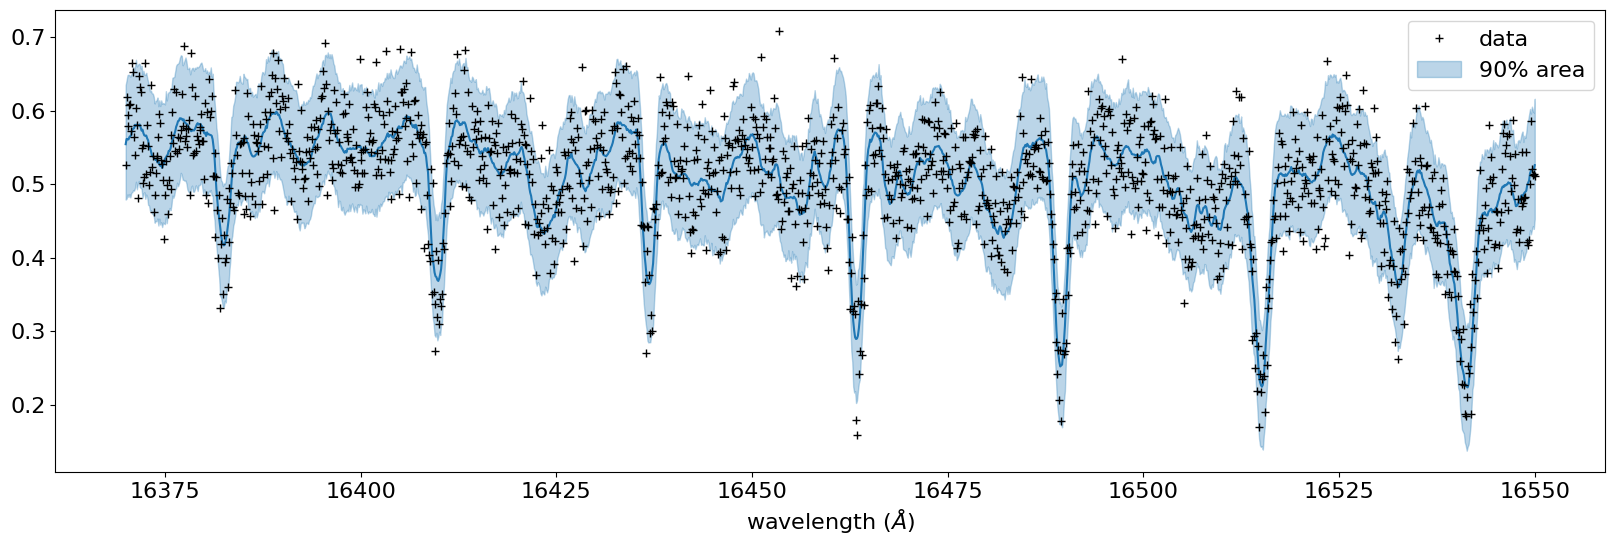

In [13]:

# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c, posterior_sample, return_sites=['y1'])
predictions = pred(rng_key_, nu1=nusd, y1=None)
median_mu1 = jnp.median(predictions['y1'], axis=0)
hpdi_mu1 = hpdi(predictions['y1'], 0.9)

# PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6.0))
ax.plot(wavd[::-1], median_mu1, color='C0')
ax.plot(wavd[::-1], nflux, '+', color='black', label='data')
ax.fill_between(wavd[::-1],
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C0',
                label='90% area')
plt.xlabel('wavelength ($\AA$)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("pred_diffmode" + str(diffmode) + ".png")
plt.show()


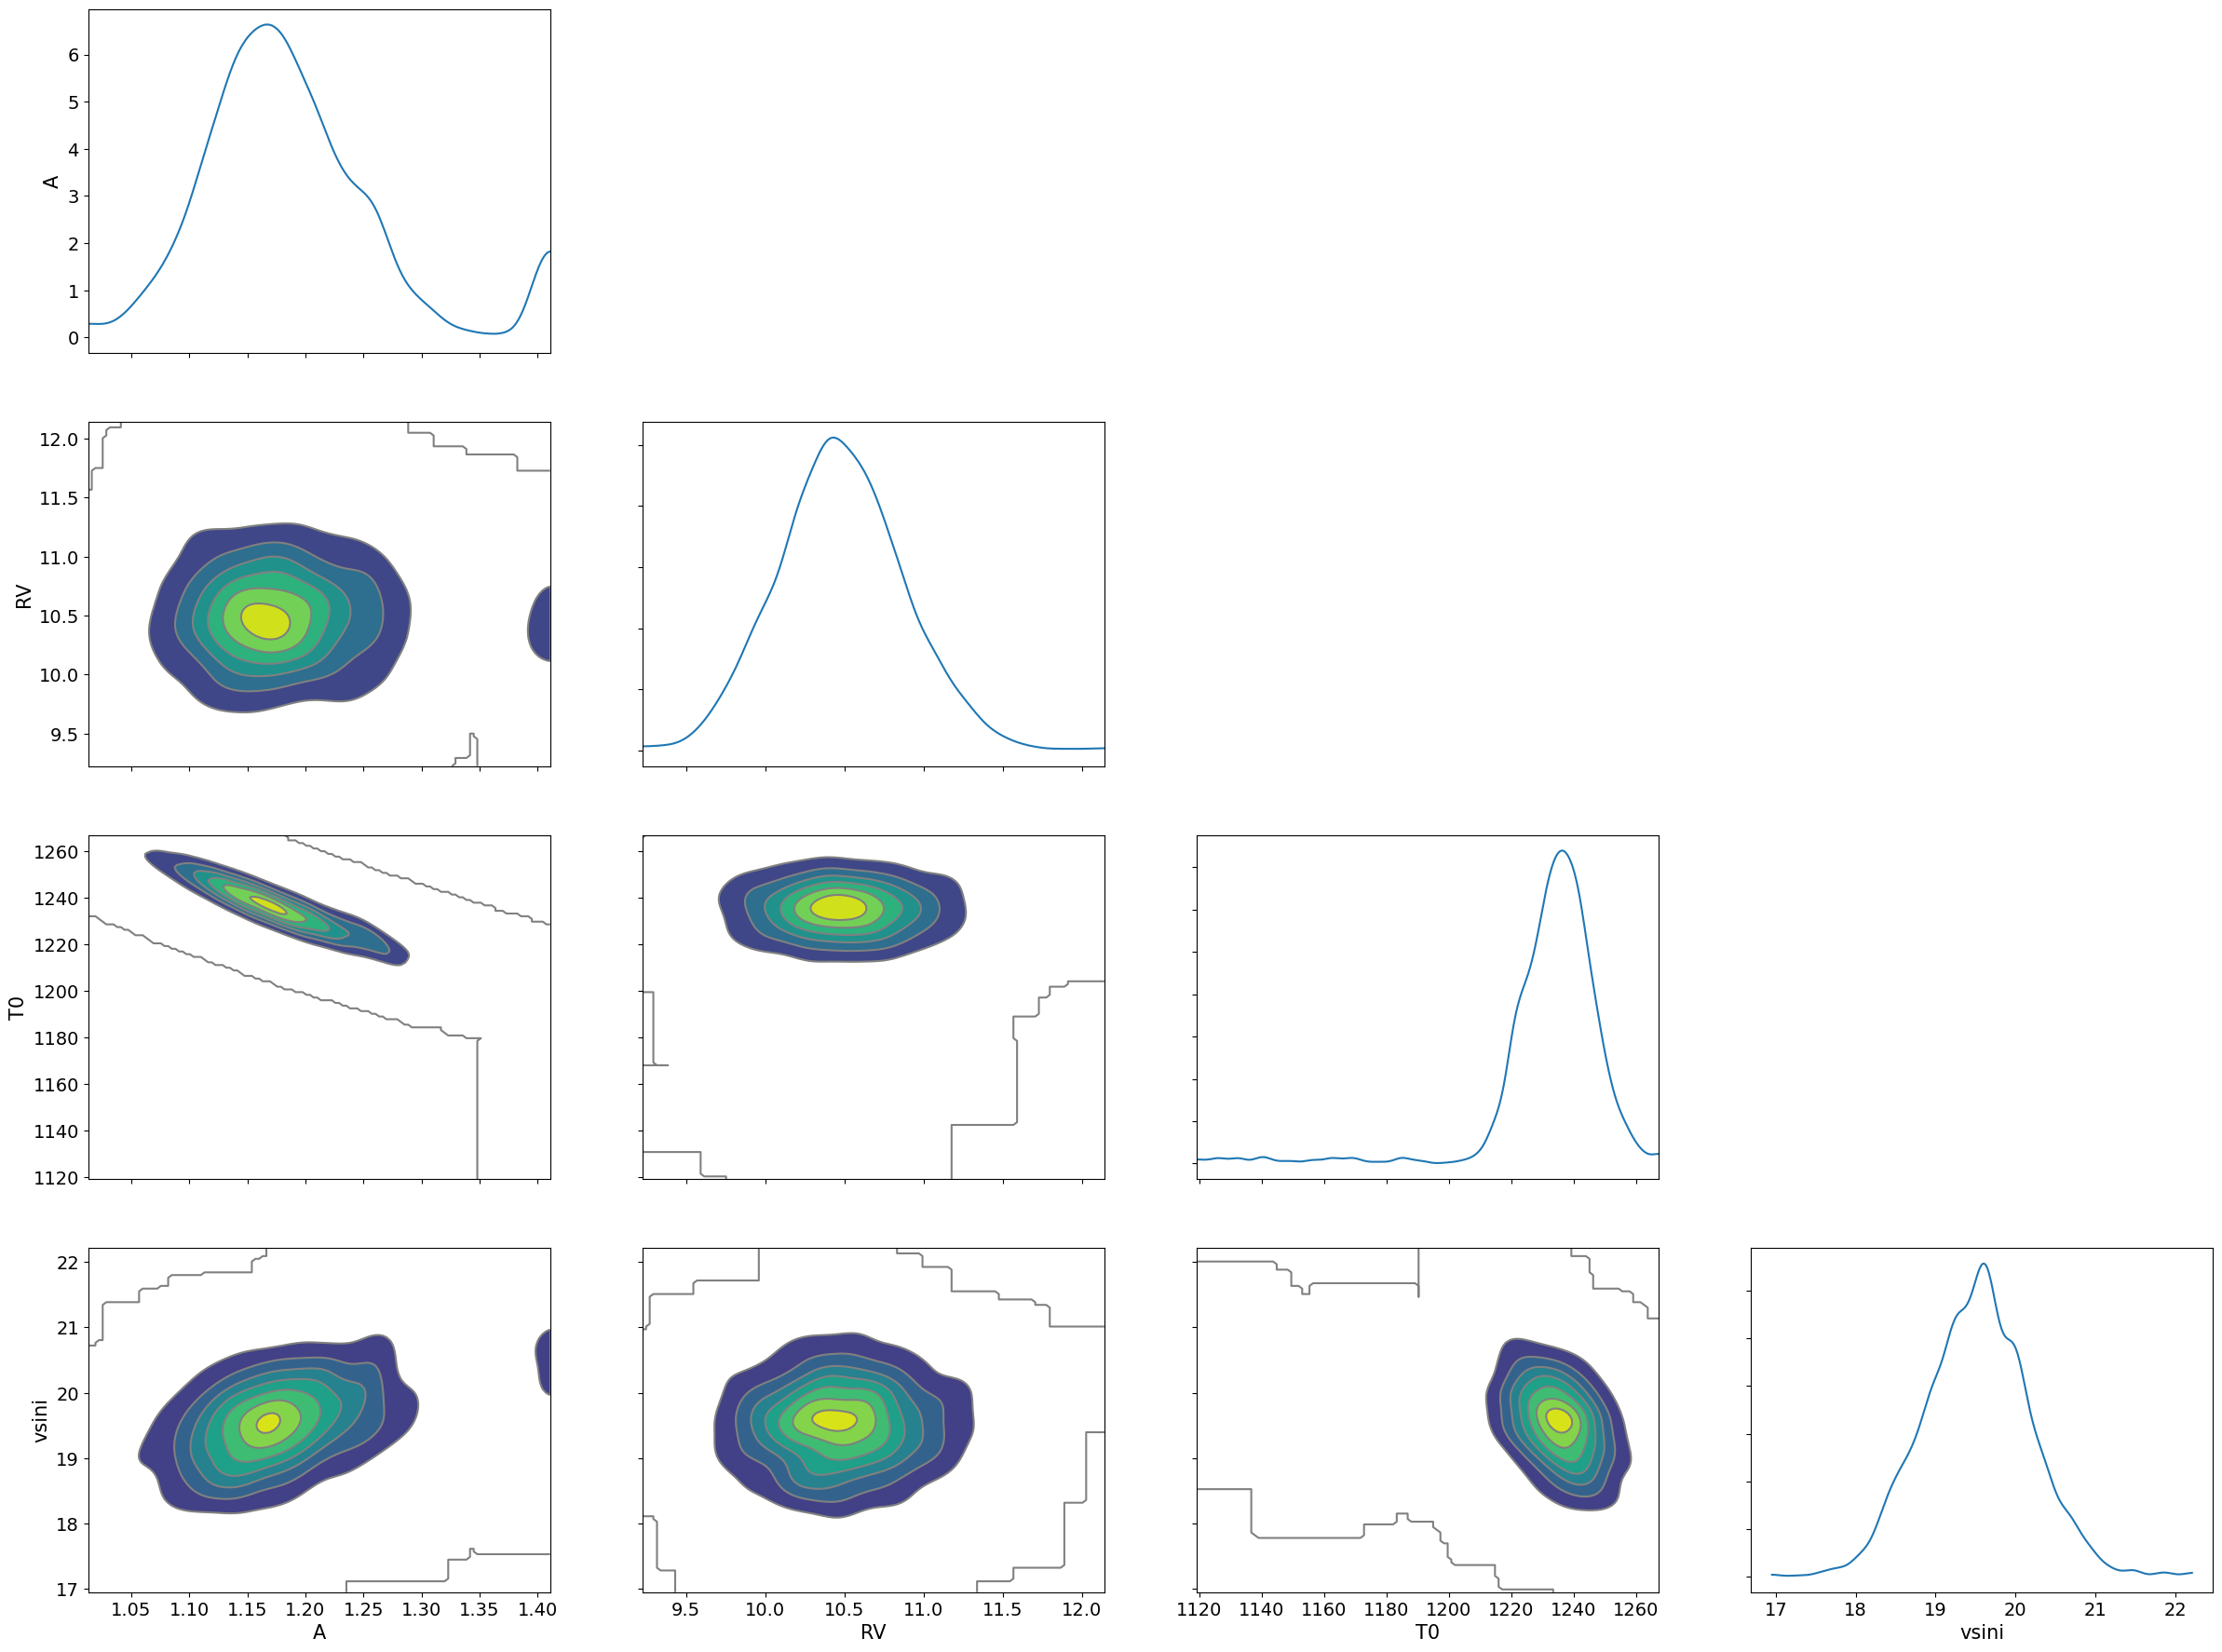

In [14]:

pararr = ['A', 'T0', 'vsini', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.savefig("corner_diffmode" + str(diffmode) + ".png")
plt.show()